In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

train_data = pd.read_csv("train.csv")
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'])

submission = pd.read_csv("test.csv")
submission['DATETIME'] = pd.to_datetime(submission['DATETIME'])


Cuda (GPU support) is not available :(


In [10]:
from sklearn.preprocessing import StandardScaler


cihaz_301 = train_data[train_data['SERVER'] == 'CIHAZ_301']
cihaz_305 = train_data[train_data['SERVER'] == 'CIHAZ_305']

cihaz_301_sub = submission[submission['SERVER'] == 'CIHAZ_301']
cihaz_305_sub = submission[submission['SERVER'] == 'CIHAZ_305']

#scaler = StandardScaler()
#scaler.fit(cihaz_301['CPULOAD'].values.reshape(-1,1))
#cihaz_301['CPULOAD'] = scaler.transform(cihaz_301['CPULOAD'].values.reshape(-1,1))
#
#scaler = StandardScaler()
#scaler.fit(cihaz_305['CPULOAD'].values.reshape(-1,1))
#cihaz_305['CPULOAD'] = scaler.transform(cihaz_305['CPULOAD'].values.reshape(-1,1))

unique_datetime1 = cihaz_301['DATETIME'].unique()
unique_datetime2 = cihaz_305['DATETIME'].unique()

grouped_301 = []
grouped_305 = []

#
#for date in unique_datetime1:
#  grouped_301.append((cihaz_301[cihaz_301['DATETIME'] == date])['CPULOAD'].to_numpy())
#
#for date in unique_datetime2:
#  grouped_305.append((cihaz_305[cihaz_305['DATETIME'] == date])['CPULOAD'].to_numpy())

cihaz_301 = cihaz_301.groupby('DATETIME')['CPULOAD'].mean().reset_index()

cihaz_305 = cihaz_305.groupby('DATETIME')['CPULOAD'].mean().reset_index()

print(cihaz_301)


                      DATETIME   CPULOAD
0    2020-03-24 00:00:00+03:00  4.425000
1    2020-03-24 00:15:00+03:00  4.427500
2    2020-03-24 00:30:00+03:00  3.910417
3    2020-03-24 00:45:00+03:00  3.633750
4    2020-03-24 01:00:00+03:00  3.575000
...                        ...       ...
5929 2020-05-24 21:15:00+03:00  9.836667
5930 2020-05-24 21:30:00+03:00  9.386667
5931 2020-05-24 21:45:00+03:00  9.413333
5932 2020-05-24 22:00:00+03:00  8.476250
5933 2020-05-24 22:15:00+03:00  6.956923

[5934 rows x 2 columns]


In [29]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination=0.004)

model.fit(cihaz_301[['CPULOAD']])

cihaz_301['anomaly']=pd.Series(model.predict(cihaz_301[['CPULOAD']])).apply(lambda x: 1 if (x == -1) else 0 )


model = IsolationForest(contamination=0.004)

model.fit(cihaz_305[['CPULOAD']])

cihaz_305['anomaly']=pd.Series(model.predict(cihaz_305[['CPULOAD']])).apply(lambda x: 1 if (x == -1) else 0 )


print(cihaz_301)

print(cihaz_305)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


                      DATETIME   CPULOAD  anomaly
0    2020-03-24 00:00:00+03:00  4.425000        0
1    2020-03-24 00:15:00+03:00  4.427500        0
2    2020-03-24 00:30:00+03:00  3.910417        0
3    2020-03-24 00:45:00+03:00  3.633750        0
4    2020-03-24 01:00:00+03:00  3.575000        0
...                        ...       ...      ...
5929 2020-05-24 21:15:00+03:00  9.836667        0
5930 2020-05-24 21:30:00+03:00  9.386667        0
5931 2020-05-24 21:45:00+03:00  9.413333        0
5932 2020-05-24 22:00:00+03:00  8.476250        0
5933 2020-05-24 22:15:00+03:00  6.956923        0

[5934 rows x 3 columns]
                      DATETIME    CPULOAD  anomaly
0    2020-03-24 00:00:00+03:00   7.084167        0
1    2020-03-24 00:15:00+03:00   6.490833        0
2    2020-03-24 00:30:00+03:00   5.668750        0
3    2020-03-24 00:45:00+03:00   5.371250        0
4    2020-03-24 01:00:00+03:00   5.005417        0
...                        ...        ...      ...
5926 2020-05-24 21

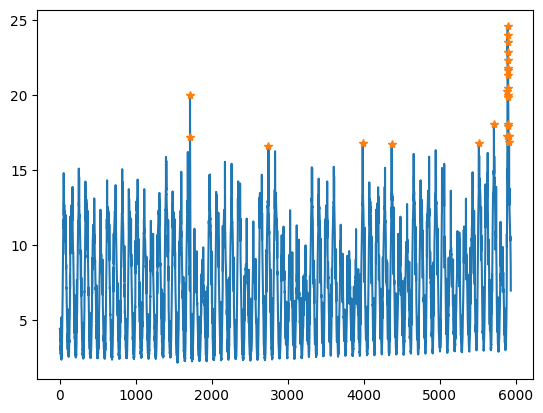

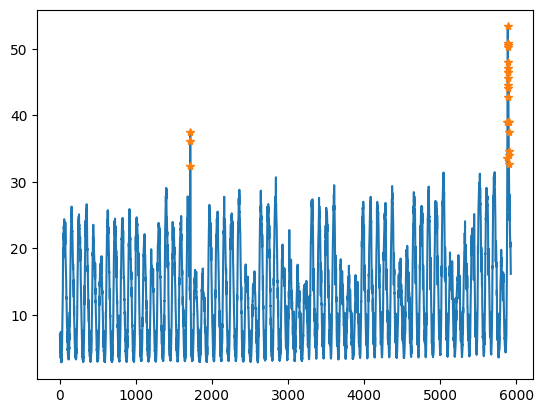

In [30]:
cihaz_301_anomalies = cihaz_301.loc[cihaz_301['anomaly'] == 1]

plt.plot(cihaz_301['CPULOAD'])
plt.plot(cihaz_301_anomalies["CPULOAD"], marker='*', linestyle="None")

plt.show()

cihaz_305_anomalies = cihaz_305.loc[cihaz_305['anomaly'] == 1]

plt.plot(cihaz_305['CPULOAD'])
plt.plot(cihaz_305_anomalies["CPULOAD"], marker='*', linestyle="None")

plt.show()

In [32]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['DATETIME']
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [40]:
train_set = cihaz_301[:4560]
#Split 2
test_set = cihaz_301[4560:]


X_train, y_train = create_features(train_set, label='CPULOAD')
X_test, y_test = create_features(test_set, label='CPULOAD')
X_submission = create_features(cihaz_301_sub)

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

<ipython-input-32-a62a6ef94452>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['DATETIME']
<ipython-input-32-a62a6ef94452>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-32-a62a6ef94452>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<ipython-input-41-eb70210fbb98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['CPU_Prediction'] = reg.predict(X_test)


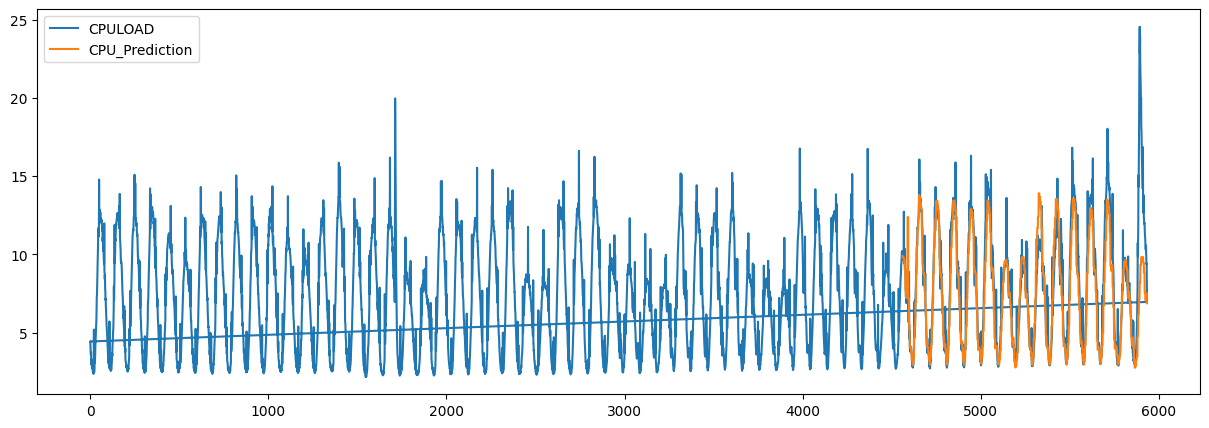

In [41]:
test_set['CPU_Prediction'] = reg.predict(X_test)
full_set = pd.concat([test_set, train_set], sort=False)

_ = full_set[['CPULOAD','CPU_Prediction']].plot(figsize=(15, 5))

In [42]:
cihaz_301_sub['CPU_Prediction'] = reg.predict(X_submission)


<ipython-input-42-df4b61fb8fee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cihaz_301_sub['CPU_Prediction'] = reg.predict(X_submission)


In [35]:
train_set = cihaz_305[:4560]
#Split 2
test_set = cihaz_305[4560:]


X_train, y_train = create_features(train_set, label='CPULOAD')
X_test, y_test = create_features(test_set, label='CPULOAD')
X_submission = create_features(cihaz_301_sub)

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

<ipython-input-32-a62a6ef94452>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['DATETIME']
<ipython-input-32-a62a6ef94452>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-32-a62a6ef94452>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<ipython-input-8-eb70210fbb98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['CPU_Prediction'] = reg.predict(X_test)


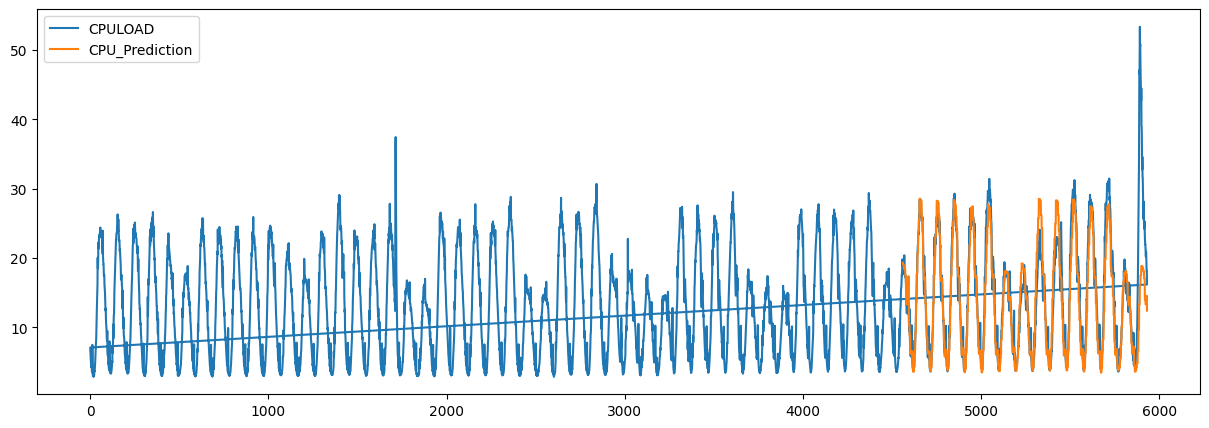

In [8]:
test_set['CPU_Prediction'] = reg.predict(X_test)
full_set = pd.concat([test_set, train_set], sort=False)

_ = full_set[['CPULOAD','CPU_Prediction']].plot(figsize=(15, 5))

In [39]:
cihaz_305_sub['CPU_Prediction'] = reg.predict(X_submission)


<ipython-input-39-cd69f49c9a43>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cihaz_305_sub['CPU_Prediction'] = reg.predict(X_submission)
